In [1]:
%matplotlib inline

# BSQ policy for the Tiger problem

## Tiger problem
- States: $s_l$, $s_r$
- Actions: openleft, openright, listen
- Observations: left, right
- Transition function: $T(* \mid *, open*) = 0.5$, $T(s \mid s, listen) = 1.0$, $T(!s \mid s, listen) = 0.0$
- Reward function: $R(s_l, openleft) = -100$, $R(s_l, openright) = 10$, $R(s_r, openright) = -100$, $R(s_r, openleft) = 10$, $R(*, listen) = -1$
- Observation function: $\Omega(left \mid s_l, listen) = 0.85$, $\Omega(right \mid s_l, listen) = 0.15$, $\Omega(right \mid s_r, listen) = 0.85$, $\Omega(left \mid s_r, listen) = 0.15$, $\Omega(* \mid *, open*) = 0.5$
- Discount factor: $0.75$


A belief state $\vec{b} = [b, 1 - b]$ gives the probability $\vec{b}(s)$ of being in state $s$. For simplicity, $b$ is the probability of being in state $s_l$, and $1 - b$ is the probability of being in state $s_r$.

In [2]:
gamma = 0.75

## An example of a BSQ policy

policy $\pi_{\theta_1, \theta_2}(b)$:
- if $b < \theta_1$ then execute openleft
- elif $b < \theta_2$ then execute listen
- else execute openright

with $\theta_1$ and $\theta_2$ as the (controlled) parameters.

In [3]:
def pi(theta1, theta2):
    return lambda b: 'openleft' if b < theta1 else ('listen' if b < theta2 else 'openright')

# One step reward function

- $R(b, a) = \sum_{s} b(s) R(s, a) = b R(s_l, a) + (1 - b) R(s_r, a)$
    - $R(b, openleft) = -110 b + 10$
    - $R(b, listen) = -1$
    - $R(b, openright) = 110 b - 100$


In [4]:
def R(a):
    if a == 'openleft':
        return lambda b: -110 * b + 10
    elif a == 'openright':
        return lambda b: 110 * b - 100
    else:
        return lambda b: -1
    
import matplotlib.pyplot as plt
import numpy as np

def plot(f, begin=0.0, end=1.0):
    x = np.arange(begin, end, 0.01)
    y = [f(i) for i in x]
    plt.plot(x, y)

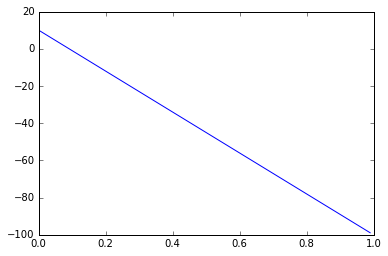

In [5]:
plot(R('openleft'))

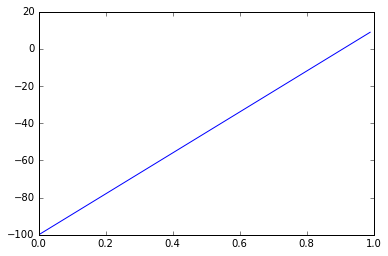

In [6]:
plot(R('openright'))

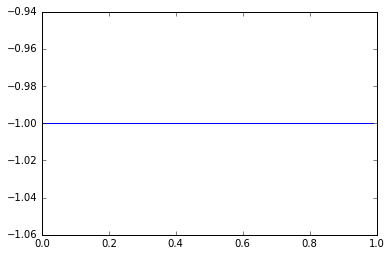

In [7]:
plot(R('listen'))

## Value function for $\pi_{\theta_1, \theta_2}$
- $b$ is the probability of being in state $s_l$
- $\tau(b, a, o)$ is the posterior probability of being in state $s_l$
- $V_0^\pi(b) = 0$
- $V_{t+1}^\pi (b) = R(b, \pi(b)) + \gamma \sum_{o} \Pr(o \mid b, \pi(b)) V_{t}^\pi (\tau(b, \pi(b), o))$
- $\Pr(o\mid b,a) = \sum_{s'} \Omega(o\mid s', a) \sum_{s}T(s'\mid s,a) b(s)$
    - $\Pr(left \mid b, openleft) = 0.5$
    - $\Pr(right \mid b, openleft) = 0.5$
    - $\Pr(left \mid b, openright) = 0.5$
    - $\Pr(right \mid b, openright) = 0.5$
    - $\Pr(left \mid b, listen) = 0.7 b + 0.15$
    - $\Pr(right \mid b, listen) = -0.7 b + 0.85$
- $\tau(b, a, o) = \eta \Omega(o \mid s',a) \sum_{s} T(s' \mid s, a)b(s)$
    - $\tau(b, openleft, left) = 0.5$
    - $\tau(b, openleft, right) = 0.5$
    - $\tau(b, openright, left) = 0.5$
    - $\tau(b, openright, right) = 0.5$
    - $\tau(b, listen, left) = 0.85 b / (0.7 b + 0.15)$
    - $\tau(b, listen, right) = 0.15 b / (-0.7 b + 0.85)$
- $\eta=1/\Pr(o\mid b,a)$

In [8]:
def Obs(o, b, a):
    if a.startswith('open'):
        return 0.5
    elif o == 'left':
        return 0.7 * b + 0.15
    elif o == 'right':
        return -0.7 * b + 0.85

def Tau(b, a, o):
    if a.startswith('open'):
        return 0.5
    elif o == 'left':
        return 0.85 * b / (0.7 * b + 0.15)
    elif o == 'right':
        return 0.15 * b / (-0.7 * b + 0.85)

def ValueIteration(V):
    """
    Return V_{t+1} according to V_{t}
    """
    def U(theta1, theta2):
        def f(b):
            a = pi(theta1, theta2)(b)
            pl = Obs('left', b, a)
            bl = Tau(b, a, 'left')
            pr = Obs('right', b, a)
            br = Tau(b, a, 'right')
            return R(a)(b) + gamma * (pl * V(theta1, theta2)(bl) + pr * V(theta1, theta2)(br))
        return f
    return U

def V(n):
    if n == 0:
        def V0(theta1, theta2):
            return lambda b: 0.0
        return V0
    return ValueIteration(V(n - 1))

## Value function almost converges at $t \ge 10$

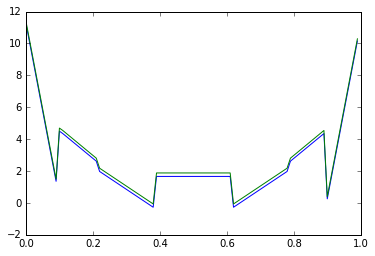

In [9]:
plot(V(10)(0.1, 0.9))
plot(V(15)(0.1, 0.9))

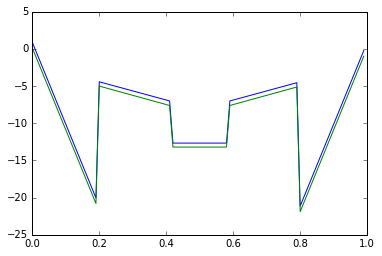

In [10]:
plot(V(10)(0.2, 0.8))
plot(V(15)(0.2, 0.8))

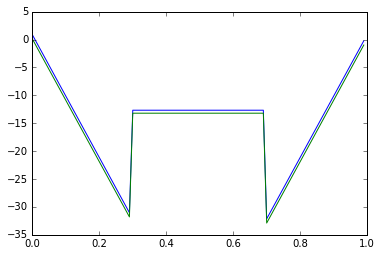

In [11]:
plot(V(10)(0.3, 0.7))
plot(V(15)(0.3, 0.7))

## Will mainly check $V_{10}$ afterwards

For different parameters $\theta_1$ and $\theta_2$, value functions differ significantly

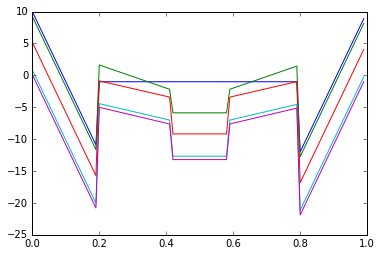

In [29]:
plot(V(1)(0.2, 0.8))
plot(V(2)(0.2, 0.8))
plot(V(4)(0.2, 0.8))
plot(V(10)(0.2, 0.8))
plot(V(15)(0.2, 0.8))

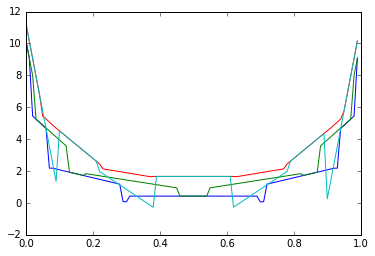

In [13]:
plot(V(10)(0.0125, 0.9875))
plot(V(10)(0.025, 0.975))
plot(V(10)(0.05, 0.95))
plot(V(10)(0.1, 0.9))

For this particular domain (Tiger), $\pi_{0.05, 0.95}$ works well, which is almost pecewise linear and convex (a property of the optimal policy).

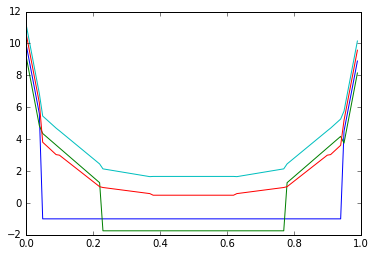

In [28]:
plot(V(1)(0.05, 0.95))
plot(V(2)(0.05, 0.95))
plot(V(4)(0.05, 0.95))
plot(V(10)(0.05, 0.95))

A general policy $\pi_{\theta_1, \theta_2}$ could have very complex shape (almost arbitrary).

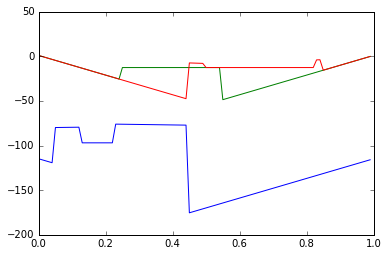

In [15]:
plot(V(10)(0.05, 0.45))
plot(V(10)(0.25, 0.55))
plot(V(10)(0.45, 0.85))

## The problem for BSQ policy is to find a (local) optimal policy by optimizing over $\theta_1$ and $\theta_2$.
- If we assume an initial belief $b_0$ (e.g. a uniform distribution), then the optimizing objective could be $V^{\pi_{\theta_1, \theta_2}}(b_0)$.
- For a fixed query belief state $b$, the surface of $V^{\pi_{\theta_1, \theta_2}}(b)$ could also be very complecated.

In [16]:
from mpl_toolkits.mplot3d import Axes3D

def plot3d(b):
    pt = []
    for theta1 in np.arange(0.0, 1.0, 0.05):
        for theta2 in np.arange(theta1, 1.0, 0.05):
            v = V(10)(theta1, theta2)(b)
            pt.append((theta1, theta2, v))
    x, y, z = zip(*pt)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('theta1')
    ax.set_ylabel('theta2')
    ax.scatter(x, y, z, c='r')

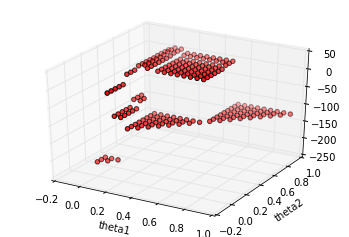

In [17]:
plot3d(b=0.1)

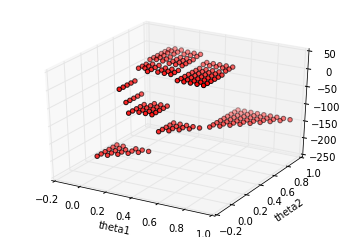

In [18]:
plot3d(b=0.25)

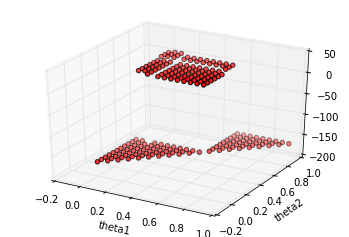

In [19]:
plot3d(b=0.5)

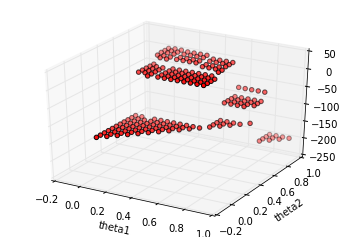

In [20]:
plot3d(b=0.75)

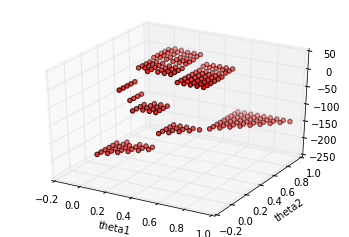

In [31]:
plot3d(b=0.3)

Assume $\theta_2 = 1.0 - \theta_1$, query the value of a belief point $b$ for different parameters.

In [22]:
def Query(b):
    def f(theta):
        return V(10)(theta, 1.0 - theta)(b)
    return f

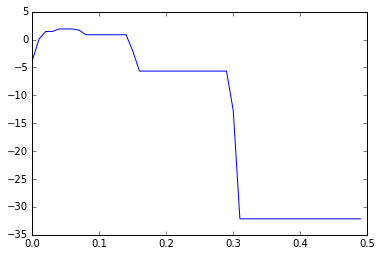

In [30]:
plot(Query(0.3), begin=0.0, end=0.5)

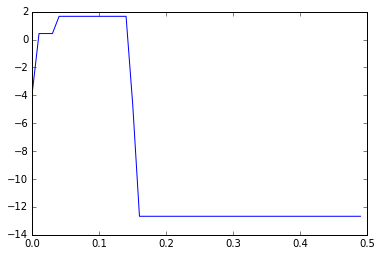

In [32]:
plot(Query(0.5), begin=0.0, end=0.5)

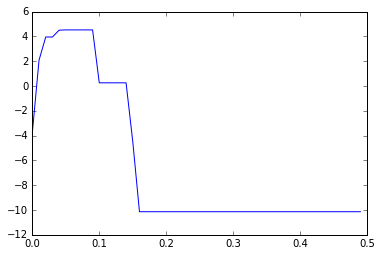

In [25]:
plot(Query(0.9), begin=0.0, end=0.5)